# Model Prototype Object

Here we take a real [Rubin Data Preview 1 (DP1)](https://dp1.lsst.io/index.html) multi-band light curve and make simulations based on it.
We will use an eclipsing binary [CRTS J061939.7-244148](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=CRTS+J061939.7-244148+&submit=SIMBAD+search), which was identified in the DP1 data by [arXiv:2506.23955](https://arxiv.org/abs/2506.23955).

Our plan is:
1. Get the light curve in ugrizy bands.
2. Period-fold it and fit with a smooth function.
3. Simulate this particular object with LSST cadence and noise properties.
4. Add samplable parameters, such as distance and period, and simulate a population.

In [ ]:
%pip install tdastro
# For data fitting
%pip install tinygp jax optax

In [2]:
import base64  # For input data decoding
import io  # For input data read

import matplotlib.pyplot as plt  # For plots
import numpy as np  # For math
import pandas as pd  # For input data loading


from tdastro.astro_utils.mag_flux import flux2mag, mag2flux  # AB mags <-> nJy
from tdastro.astro_utils.passbands import PassbandGroup  # Filter transmissions
from tdastro.base_models import FunctionNode  # Define custom parameter samplers
from tdastro.math_nodes.np_random import NumpyRandomFunc  # Parameter sampling with numpy.random
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler  # Sky position sampling
from tdastro.opsim.opsim import OpSim  # Deal with LSST cadence and noise simulations
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.lightcurve_source import LightcurveSource  # Source model


# For input data interpolation with tinygp
import flax.linen  # For optimizable model creation
import flax.linen.initializers as flax_init  # For parameter initialization
import jax  # Framework tinygp based on
import jax.numpy as jnp  # Jax's implementation of numpy's API
import optax  # Gradient slope optimization framework
from tinygp import kernels, GaussianProcess  # For interpolation

# Ask Jax to use float64, it is for numerical stability of interpolation
jax.config.update("jax_enable_x64", True)

### 1. Getting the light curve

Since there is no public service to query for DP1 light curves (but if you have Rubin data rights see https://lsdb.io/dp1), we'd just use data copy-pasted here.
We use light-curve from the LINCC Frameworks' [DP1 HATS dataset](https://lsdb.io/dp), which includes AB magnitude values converted from band fluxes.

We will also use the [ZTF](https://www.ztf.caltech.edu) DR23 light curve, because it has a better phase coverage and would help to interpolate data better.
We are accessing ZTF data through the [SNAD Viewer](https://ztf.snad.space/dr23/view/258108100003289).

In [3]:
# From Malanchev+2025
PERIOD = 0.2407795
# From Bailer-Jones+2021
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ68839f64fdcc9&-out.add=.&-source=I/352/gedr3dis&-c=094.91625157166%20-24.69649640201,eq=ICRS,rs=2&-out.orig=o
DISTANCE = 1653.999
ENCODED_DATA = """
UEFSMRUEFTwVQkwVDBUAEgAAKLUv/SAexQAA4gEFC+BpDEHT7QDAIZkC9c0Hn3zx0RcAFQAVlgEVqAEsFYgDFRAVBhUGHAAAACi1L/0gS1kCAAMAAACIAwED
FwAAJJEkSduWJAmlbRtJktwmadtIkuQmSdK2kSRJSluSTRACA9vatkQFEdskSZK2bW3bVpK0bZskSZIkbds2SRIAABUEFcAYFbYNTBWIAxUAEgAAKLUv/WAg
BY0aAKQyFmSBWkqb7UDrBNBpo03IbjwQX3SgYUF5CQvth/K1UZMPLMCiGKWbpxY3HbETAvO1wAmsujITr7/ecsqpJpztQIjKYbPXGym90DJPy83lOtAeCqbt
NGnyMpOW/IX9NAEnIIfPD+EWFxaylQkbYUQKINVErPajWq/AM8rOak08QPc0Rd61bkka4tJN6hf9UbR2clbkJ6lgCDCSati2dm9YgV50lL4Nej26f+q7ko7E
v8+c5GpBofo1halFfwx36SdRSH9temiD2gLzipWNDY9y2CuTnmVEl/4GTqV+niyqvwYErzgW7rNQJe+4FHRlvrte+9EoE3nlShKx7dawUvY6Uo3+tv3Mc+ro
6913Dmn+e9EQV4S2TQWM6BIekDuJj5SYDLqYtD84p8M9Iazni/6wQkbftWEg0bp5kBbBnd7zxfIDt9RALRliBJ3tQHgpxHHjTfd9yznVgaSNcaI1JDCnvPMu
qw9EisNQG13PnOnF1iwrlubO6SLrqmwM75osBvMWN/H6enAugolY7mGFfpL6jm5VSZay16WcWqAXow6Jkavv27yuKAEttTC+WrgReoS7v0PBvjD3HsJH30/F
DDyCyPGJtstCs+zONiUd0qLjWNWIs/nb/rQx375O2uhn6g7sNJ5G74IHefKZDqr1RhPs+DQ3Mf12d2YAiiyOoQO1c9kG3hQHCvCMMg1ODKgTw/jcFmQtQx1z
CpYgTN04Koi3Wy2FLcwzkn4AN8/INzrTvqpA+b3kQ83UTkq6SDBSqid6Va6HMF9O/yRm/oSabNZAxG9ebVx36HaLeroBA2PKMlZ1aYTvv2ymU+JzqjsTd0ZI
R3pBu6F9GircgJ6nfImAb9iPbB4Pk59gVJaLcM+aJiconspiA6g0AFTpJ+YvV27Za1rGRZ5dVO7FYPIuWWaBPYRpVJCvbPBWw3YzeTh9qQdmgDU4Sopam4aN
jVi+kJn8Npc2Ss6boPn8nmpvOaJX+2ilHn5spgqe7UBGAtSs6CUCsAM/LLPgj5q6WPXKvUai+8BjCoLMfIvk0j/jENa6eErZKp1P4PHuheNE/7vm1Ml37ZJ9
8/AKnu1AgL+oEBTeduAPMPwaUAXWbiKFGVCCrKLd+OXg8j3ZHoxmVOVOKRUAFaIDFbQDLBWIAxUQFQYVBhwAAAAotS/9INGJBgADAAAAiAMBCDMAAQIDBAUG
BwgJCgsMDQ4PEBESExQVFhcYGRobHB0eHyAhIiMkJSYnKCkqKywtLi8wMTIzNDU2Nzg5Ojs8PT4/QEFCQ0RFRkdISUpLTE1OT1BRUlNUVVZXWFlaW1xdXl9g
YWJjZGVmZ2hpamtsbW5vcHFyc3R1dnd4eXp7fH1+f4CBgoOEhYaHiImKi4yNjo+QkZKTlJWWl5iZmpucnZ6foKGio6SlpqeoqaqrrK2ur7CxsrO0tba3uLm6
u7y9vr/AwcLDAAAAABUEFaAMFdAKTBWIAxUAEgAAKLUv/WAQAvUUAIYvokJw3kprMWACYSg+Qysj8RQWd3BOgj1WJaVi/xqR+xC595byl6XlM2yNBMs77Ay4
7olBUbHSYfo4NQk8X+B3EmEcbQuUAJEAjQDftLZvWd/VBxe668n2DSHg6/bja+HJ6BWm0S5Jo3pytIyieTMa5szomqgvEQ1fHXzfIh6+TaJ87/iuatJc7YxZ
xxp6uYDNZZOIy6mvS2CZSyuuSwhdDz+YeIi25Tc9QX6Dg2ZzxIBNCQ42f7wmpb5MKkmZLNqwlTPh6pM+wkl7vLJn8QItkgVYvAC1iKLGIhhw0aksRj0eIhDz
UCvvoRndF2vOdyvFF6jkCsd2zUF1tXxXN/FaHrmuFX3DEgxZlAFmccSSxRhN3wJ2X6yfqxbeFWh3yuXGKQ8op0m8TuWWTmdIndqj06uh064KC2dYWOiGZeHa
noVqULYm3tM2w29rVne1WVciZr4wcHxVCI12AY4u2cMaRaJi9M7WKBCq0Spa6PfMQH3ByS1pk0yWtm1k2xUctjXitnZh27nhwrPNwiIvFjqBe/RSehxjekQL
eiTh83iTHneokXmky/KoN/a4h+PRjL0iCV2NvK5QbdeFXMXYXFEgXTvAuLqIEnWds1e8Idc7JFcqVq5rAFz7srYR4LZXRFvgge0ZcBs02rrV2Zpz2zgN2yBR
2zyhLZXgNs7TZNcbOa5oen2DupZd15Ht+1X1pfLyncX3qsRXCu07JfZ9oHY9u7t20HIlpVwxNNg0kWdzDcgmCAybHoA2KdRtWnFtOvHYrAL7jUjuM46bTy9/
6in4NBL3SQ5dtrC6DMpdngheooW4NBOyZTDcHv2uePBcz9C57tG4Tqm75jH5BAZ9Ku19/oSfBH7bsONjMggEAPEg4MUi3TwAhGu/gN5cedEVABWiAxW0AywV
iAMVEBUGFQYcAAAAKLUv/SDRiQYAAwAAAIgDAQgzAAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDEyMzQ1Njc4OTo7
PD0+P0BBQkNERUZHSElKS0xNTk9QUVJTVFVWV1hZWltcXV5fYGFiY2RlZmdoaWprbG1ub3BxcnN0dXZ3eHl6e3x9fn+AgYKDhIWGh4iJiouMjY6PkJGSk5SV
lpeYmZqbnJ2en6ChoqOkpaanqKmqq6ytrq+wsbKztLW2t7i5uru8vb6/wMHCwwAAAAAVBBWgDBXQC0wViAMVABIAACi1L/1gEAL1FgCmsLQrYPR0j+bdqJ9+
XvUCzaJ0BVOVRCURB0/5Bh9gkQ3hRxMRj1UDufgL3k6vKKkAqgCpAJ1ted8ezHq5POnj8vQ+DuH8bK31i1J6vXsUo69msfvpIm4HJYV33hq8niuL1OOVuj13
NfyqTTD/WYfyn03pJ43FeNAei0dzIH0cVxk5BFzy7U7AD3Uy/DaO5Lu31v/Gi79nLtrHgB8dgc/cC14cu/hC6zHVFV9ZFvOUKoSPuHfyiRuMnzZEPyFP/NNj
MZ8eXH9h5EeXsQLrT2XYXR42Oktn3lsaxbqLgVV94X3uDRVNPcEsAv6eG0nPZi35s7j0774Tb778+vOPxJvhAW8+w3rOQrdnP9G9+Ufk6dZUv25k9j/js89W
p37dzdnX7XqQw3a944ZOkAPWVOSCF5PDfXvksOANOS/rkcFqq88Kt/KoskGPCrT+VLnA93vI+TvFwbS/89v6uZ+Ol3s5/DZT+tk7Fv0VKZcMEDrQ4wUkndZS
hPwVUui0Q3m91XP9bdfbb9O+fWpNnGcUm70eY8fztVq+H2fM57FB/p5Rx68SwfysEum3Zs18ezPnW21U3xQs8UNLSF/04uZFlT5/1AHi26Ovn+p59fAV3a+d
0frYsdLf3pYfXoT7rn+2H4difdy8/K1wpn9NufrX3JKPZWN62lzo47GNr5vHdDCIUf82IXWAoPfnJkk9b4b6d8m0nhdkswds5R2gBrEDSPYewLX0vG4D3xuo
+rxz5/7tXAmP7kQ/3mbs70UBvt3P7dtVbb3pqs+7dd7/5rt4t5fJu6M0/o3y8e6Djz+3lR+dpniziuabacL+cgftJ2Uwf5IC5SXRPh8zjPicvfTdJh4ve0XZ
xxmzXfzG6+Ebzi4wt9MJGMJ9rCH2mHXof3Tr/roD7xnBK+84ldQPaHQ7QVm5D3h0dXDGUv+qN7/W5Ohp00V9nIbteYtiz+OZXVzQe/5rrya0+wIA/d8A0Q+4
UhUAFaIDFbQDLBWIAxUQFQYVBhwAAAAotS/9INGJBgADAAAAiAMBCDMAAQIDBAUGBwgJCgsMDQ4PEBESExQVFhcYGRobHB0eHyAhIiMkJSYnKCkqKywtLi8w
MTIzNDU2Nzg5Ojs8PT4/QEFCQ0RFRkdISUpLTE1OT1BRUlNUVVZXWFlaW1xdXl9gYWJjZGVmZ2hpamtsbW5vcHFyc3R1dnd4eXp7fH1+f4CBgoOEhYaHiImK
i4yNjo+QkZKTlJWWl5iZmpucnZ6foKGio6SlpqeoqaqrrK2ur7CxsrO0tba3uLm6u7y9vr/AwcLDAAAAABUEGVw1ABgGc2NoZW1hFQgAFQwlAhgEYmFuZCUA
TBwAAAAVCiUCGA5taWRwb2ludE1qZFRhaQAVCCUCGAZwc2ZNYWcAFQglAhgJcHNmTWFnRXJyABaIAxkcGUwmABwVDBk1AAYQGRgEYmFuZBUMFogDFpoCFrIC
JmYmCCksFQQVABUCABUAFRAVAgA8FogDGQYZJgCIAwAAACYAHBUKGTUABhAZGA5taWRwb2ludE1qZFRhaRUMFogDFrAcFrgRJpIQJroCKSwVBBUAFQIAFQAV
EBUCADwpBhkmAIgDAAAAJgAcFQgZNQAGEBkYBnBzZk1hZxUMFogDFpAQFtIOJuQeJvITKSwVBBUAFQIAFQAVEBUCADwpBhkmAIgDAAAAJgAcFQgZNQAGEBkY
CXBzZk1hZ0VychUMFogDFpAQFtIPJrYuJsQiKSwVBBUAFQIAFQAVEBUCADwpBhkmAIgDAAAAFuo+FogDJggWjjIAGSwYBnBhbmRhcxjgBHsiaW5kZXhfY29s
dW1ucyI6IFtdLCAiY29sdW1uX2luZGV4ZXMiOiBbXSwgImNvbHVtbnMiOiBbeyJuYW1lIjogImJhbmQiLCAiZmllbGRfbmFtZSI6ICJiYW5kIiwgInBhbmRh
c190eXBlIjogInVuaWNvZGUiLCAibnVtcHlfdHlwZSI6ICJvYmplY3QiLCAibWV0YWRhdGEiOiBudWxsfSwgeyJuYW1lIjogIm1pZHBvaW50TWpkVGFpIiwg
ImZpZWxkX25hbWUiOiAibWlkcG9pbnRNamRUYWkiLCAicGFuZGFzX3R5cGUiOiAiZmxvYXQ2NCIsICJudW1weV90eXBlIjogImZsb2F0NjQiLCAibWV0YWRh
dGEiOiBudWxsfSwgeyJuYW1lIjogInBzZk1hZyIsICJmaWVsZF9uYW1lIjogInBzZk1hZyIsICJwYW5kYXNfdHlwZSI6ICJmbG9hdDMyIiwgIm51bXB5X3R5
cGUiOiAiZmxvYXQzMiIsICJtZXRhZGF0YSI6IG51bGx9LCB7Im5hbWUiOiAicHNmTWFnRXJyIiwgImZpZWxkX25hbWUiOiAicHNmTWFnRXJyIiwgInBhbmRh
c190eXBlIjogImZsb2F0MzIiLCAibnVtcHlfdHlwZSI6ICJmbG9hdDMyIiwgIm1ldGFkYXRhIjogbnVsbH1dLCAiY3JlYXRvciI6IHsibGlicmFyeSI6ICJw
eWFycm93IiwgInZlcnNpb24iOiAiMjAuMC4wIn0sICJwYW5kYXNfdmVyc2lvbiI6ICIyLjMuMSJ9ABgMQVJST1c6c2NoZW1hGPgJLy8vLy83QURBQUFRQUFB
QUFBQUtBQTRBQmdBRkFBZ0FDZ0FBQUFBQkJBQVFBQUFBQUFBS0FBd0FBQUFFQUFnQUNnQUFBSmdDQUFBRUFBQUFBUUFBQUF3QUFBQUlBQXdBQkFBSUFBZ0FB
QUJ3QWdBQUJBQUFBR0FDQUFCN0ltbHVaR1Y0WDJOdmJIVnRibk1pT2lCYlhTd2dJbU52YkhWdGJsOXBibVJsZUdWeklqb2dXMTBzSUNKamIyeDFiVzV6SWpv
Z1czc2libUZ0WlNJNklDSmlZVzVrSWl3Z0ltWnBaV3hrWDI1aGJXVWlPaUFpWW1GdVpDSXNJQ0p3WVc1a1lYTmZkSGx3WlNJNklDSjFibWxqYjJSbElpd2dJ
bTUxYlhCNVgzUjVjR1VpT2lBaWIySnFaV04wSWl3Z0ltMWxkR0ZrWVhSaElqb2diblZzYkgwc0lIc2libUZ0WlNJNklDSnRhV1J3YjJsdWRFMXFaRlJoYVNJ
c0lDSm1hV1ZzWkY5dVlXMWxJam9nSW0xcFpIQnZhVzUwVFdwa1ZHRnBJaXdnSW5CaGJtUmhjMTkwZVhCbElqb2dJbVpzYjJGME5qUWlMQ0FpYm5WdGNIbGZk
SGx3WlNJNklDSm1iRzloZERZMElpd2dJbTFsZEdGa1lYUmhJam9nYm5Wc2JIMHNJSHNpYm1GdFpTSTZJQ0p3YzJaTllXY2lMQ0FpWm1sbGJHUmZibUZ0WlNJ
NklDSndjMlpOWVdjaUxDQWljR0Z1WkdGelgzUjVjR1VpT2lBaVpteHZZWFF6TWlJc0lDSnVkVzF3ZVY5MGVYQmxJam9nSW1ac2IyRjBNeklpTENBaWJXVjBZ
V1JoZEdFaU9pQnVkV3hzZlN3Z2V5SnVZVzFsSWpvZ0luQnpaazFoWjBWeWNpSXNJQ0ptYVdWc1pGOXVZVzFsSWpvZ0luQnpaazFoWjBWeWNpSXNJQ0p3WVc1
a1lYTmZkSGx3WlNJNklDSm1iRzloZERNeUlpd2dJbTUxYlhCNVgzUjVjR1VpT2lBaVpteHZZWFF6TWlJc0lDSnRaWFJoWkdGMFlTSTZJRzUxYkd4OVhTd2dJ
bU55WldGMGIzSWlPaUI3SW14cFluSmhjbmtpT2lBaWNIbGhjbkp2ZHlJc0lDSjJaWEp6YVc5dUlqb2dJakl3TGpBdU1DSjlMQ0FpY0dGdVpHRnpYM1psY25O
cGIyNGlPaUFpTWk0ekxqRWlmUUFBQUFBR0FBQUFjR0Z1WkdGekFBQUVBQUFBdUFBQUFHZ0FBQUE0QUFBQUJBQUFBR2ovLy84QUFBRURFQUFBQUJ3QUFBQUVB
QUFBQUFBQUFBa0FBQUJ3YzJaTllXZEZjbklBQUFDZS8vLy9BQUFCQUpqLy8vOEFBQUVERUFBQUFCZ0FBQUFFQUFBQUFBQUFBQVlBQUFCd2MyWk5ZV2NBQU1y
Ly8vOEFBQUVBeFAvLy93QUFBUU1RQUFBQUtBQUFBQVFBQUFBQUFBQUFEZ0FBQUcxcFpIQnZhVzUwVFdwa1ZHRnBBQUFBQUFZQUNBQUdBQVlBQUFBQUFBSUFF
QUFVQUFnQUJnQUhBQXdBQUFBUUFCQUFBQUFBQUFFRkVBQUFBQndBQUFBRUFBQUFBQUFBQUFRQUFBQmlZVzVrQUFBQUFBUUFCQUFFQUFBQUFBQUFBQT09ABgg
cGFycXVldC1jcHAtYXJyb3cgdmVyc2lvbiAyMC4wLjAZTBwAABwAABwAABwAAAAWCQAAUEFSMQ==
"""

##### Rubin DP1 data

In [4]:
decoded_data = base64.b64decode(ENCODED_DATA)
io_stream = io.BytesIO(decoded_data)
input_lsst_df = pd.read_parquet(io_stream)
input_lsst_df = input_lsst_df.rename(
    columns={"midpointMjdTai": "mjd", "psfMag": "mag", "psfMagErr": "magerr"}
)
input_lsst_df

,band,mjd,mag,magerr
0,y,60634.323548,16.521154,0.002976
1,y,60634.325417,16.536283,0.002972
...,...,...,...,...
194,r,60656.341488,16.823532,0.001334
195,r,60656.341913,16.821083,0.001311


##### ZTF data

In [5]:
input_ztf_df = pd.read_csv(
    "https://ztf.snad.space/dr23/csv/258108100003289?other_oid=258208100005846&min_mjd=50000&max_mjd=70000"
)
input_ztf_df = input_ztf_df.rename(columns={"filter": "band"})[["band", "mjd", "mag", "magerr"]]
input_ztf_df

,band,mjd,mag,magerr
0,zr,58397.52198,17.228245,0.018987
1,zr,58422.50484,16.731781,0.014676
...,...,...,...,...
457,zg,60608.46133,17.776928,0.031371
458,zr,60608.50506,16.915134,0.016023


##### All the data all together

In [6]:
input_df = pd.concat([input_lsst_df, input_ztf_df], axis=0, ignore_index=True)
mjd_min_light = input_df["mjd"][input_df.query("band == 'r'")["mag"].idxmax()]
input_df["phase"] = (input_df["mjd"] - mjd_min_light) % PERIOD / PERIOD
input_df

,band,mjd,mag,magerr,phase
0,y,60634.323548,16.521154,0.002976,0.352477
1,y,60634.325417,16.536283,0.002972,0.360237
...,...,...,...,...,...
653,zg,60608.461330,17.776928,0.031371,0.942095
654,zr,60608.505060,16.915134,0.016023,0.123714


#### Let's plot the light curve

ZTF bands have "z" prefix.

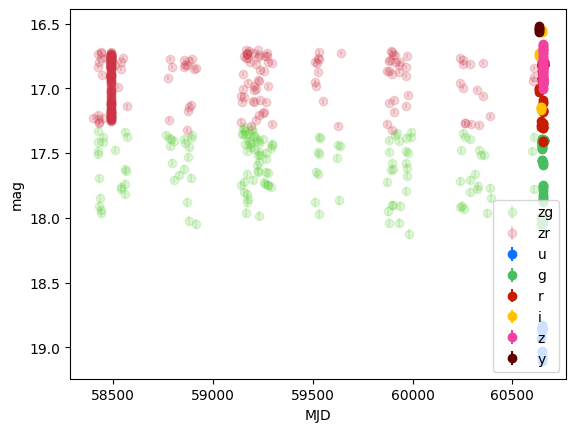

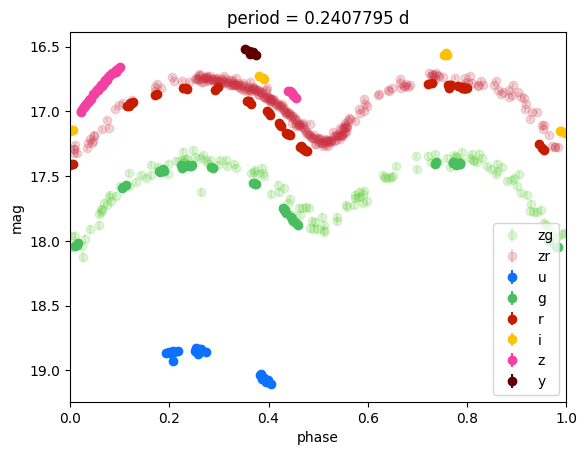

In [7]:
COLORS = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
    "zg": "#62D03E",
    "zr": "#CC3344",
}


def plot_lc(df, period=None):
    df = df.copy()
    if period is not None and "phase" not in df.columns:
        mjd_min_light = df["mjd"][df.query("band == 'r'")["mag"].idxmax()]
        df["phase"] = (df["mjd"] - mjd_min_light) % period / period
    if period is None:
        x_col = "mjd"
    else:
        x_col = "phase"
    plt.figure()
    if len({"zg", "zr"} & set(df["band"])) > 0:
        for band in ["zg", "zr"]:
            data = df.query("band == @band")
            plt.errorbar(
                data[x_col],
                data["mag"],
                yerr=data["magerr"],
                label=f"{band}",
                fmt="o",
                color=COLORS[band],
                alpha=0.2,
            )
    for band in "ugrizy":
        data = df.query("band == @band")
        plt.errorbar(
            data[x_col], data["mag"], yerr=data["magerr"], label=f"{band}", fmt="o", color=COLORS[band]
        )

    plt.gca().invert_yaxis()
    if period is None:
        plt.xlabel("MJD")
    else:
        plt.xlabel("phase")
        plt.xlim([0, 1])
        plt.title(f"{period = } d")
    plt.ylabel("mag")
    plt.legend(loc="lower right")


plot_lc(input_df, period=None)
plot_lc(input_df, period=PERIOD)

### 2. Make a smooth interpolation of a period-folded light-curve

We are using [`tinygp`](https://tinygp.readthedocs.io/) for Gaussian process fit of our data.
Our Gaussian process kernel has two components: a periodic one for correlation in time, and an exponential for wavelengths, which helps reconstruct Rubin light curves based on correlation with ZTF data.
We are going to use mean of the result Gaussian process as light curve "interpolation" result.

In [8]:
# https://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=LSST&asttype=
# https://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
EFF_WAVELENGTH = {
    "u": 3751.20,
    "g": 4740.66,
    "r": 6172.34,
    "i": 7500.97,
    "z": 8678.90,
    "y": 9711.82,
    "zg": 4746.48,
    "zr": 6366.38,
}

LG_EFF_WAVELENGTH = {band: np.log10(v) for band, v in EFF_WAVELENGTH.items()}
LG_EFF_WAVELENGTH_BY_POSITION = jnp.array(list(LG_EFF_WAVELENGTH.values()))

MEAN_MAGS = jnp.array([input_df.query("band == @band")["mag"].mean() for band in LG_EFF_WAVELENGTH])

N_BANDS = len(LG_EFF_WAVELENGTH)
# Mapping like 'g' -> [0, 1, 0, 0, 0, 0, 0, 0]
BAND_ENCODINGS = {
    band: np.r_[[0] * i, 1.0, [0] * (N_BANDS - i - 1)] for i, band in enumerate(LG_EFF_WAVELENGTH)
}
BAND_ENCODINGS

INFO:2025-07-25 13:25:47,590:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-07-25 13:25:47,590 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


{'u': array([1., 0., 0., 0., 0., 0., 0., 0.]),
 'g': array([0., 1., 0., 0., 0., 0., 0., 0.]),
 'r': array([0., 0., 1., 0., 0., 0., 0., 0.]),
 'i': array([0., 0., 0., 1., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 1., 0., 0., 0.]),
 'y': array([0., 0., 0., 0., 0., 1., 0., 0.]),
 'zg': array([0., 0., 0., 0., 0., 0., 1., 0.]),
 'zr': array([0., 0., 0., 0., 0., 0., 0., 1.])}

Array([19.46200164, 19.46185637, 19.46155957, ..., 17.31522334,
       17.31538261, 17.31538941], dtype=float64)

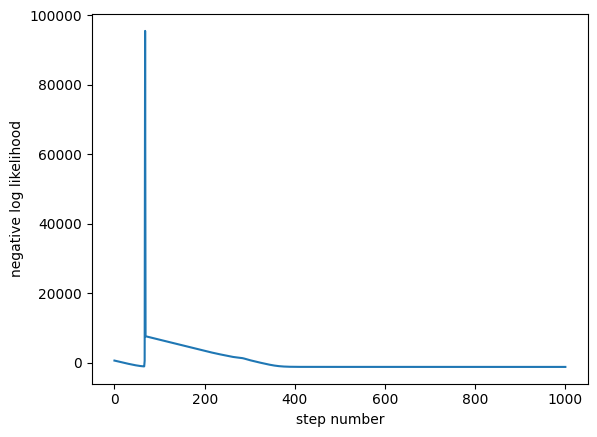

In [9]:
# Adopted from tinygp docs
# https://tinygp.readthedocs.io/en/stable/tutorials/quickstart.html
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html#optimization-with-flax-optax


class PhaseDistance(kernels.Distance):
    """Distance between two points in phase, time being the first axis"""

    def distance(self, X1, X2):
        return jnp.sum(jnp.abs(X1[..., 0] - X2[..., 0]))


def get_band_idx(X):
    return jnp.sum(X[..., 1:].astype(int) * jnp.arange(N_BANDS), axis=-1)


class BandDistance(kernels.Distance):
    """Distance between two passbands, one-hot encoded in all axis but first"""

    def distance(self, X1, X2):
        ln_wave_1 = LG_EFF_WAVELENGTH_BY_POSITION[get_band_idx(X1)]
        ln_wave_2 = LG_EFF_WAVELENGTH_BY_POSITION[get_band_idx(X2)]
        return jnp.sum(jnp.abs(ln_wave_1 - ln_wave_2))


def get_mean(means, X):
    band_idx = get_band_idx(X)
    return means[band_idx]


class GPModule(flax.linen.Module):
    @flax.linen.compact
    def __call__(self, x, yerr, y, t):
        means = self.param("mean", lambda *_: MEAN_MAGS)
        periodic_var = jnp.exp(2.0 * self.param("ln_periodic_sigma", flax_init.zeros, ()))
        periodic_gamma = jnp.exp(self.param("ln_periodic_gamma", flax_init.zeros, ()))
        band_var = jnp.exp(2.0 * self.param("ln_band_sigma", flax_init.zeros, ()))
        band_scale = jnp.exp(self.param("ln_band_scale", flax_init.zeros, ()))
        extra_diag = jnp.exp(self.param("ln_extra_diag", flax_init.zeros, ()))

        periodic_kernel = periodic_var * kernels.ExpSineSquared(
            gamma=periodic_gamma,
            scale=1.0,
            distance=PhaseDistance(),
        )
        band_kernel = band_var * kernels.ExpSquared(scale=band_scale, distance=BandDistance())
        kernel = periodic_kernel + band_kernel

        gp = GaussianProcess(
            kernel,
            x,
            diag=yerr**2 + extra_diag,
            mean=lambda X: get_mean(means, X),
        )

        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc


band_one_hot = np.asarray([BAND_ENCODINGS[x] for x in input_df["band"]])
t = np.hstack([input_df["phase"].to_numpy()[:, None], band_one_hot])
y = input_df["mag"].to_numpy()
yerr = input_df["magerr"].to_numpy()
n_grid_band = 1000

phase_gp_grid = jnp.tile(jnp.linspace(0, 1, n_grid_band), N_BANDS)
band_gp_grid = np.repeat(list(BAND_ENCODINGS.keys()), n_grid_band)
band_gp_grid_one_hot = jnp.repeat(jnp.eye(N_BANDS), n_grid_band, axis=0)
t_gp_grid = jnp.hstack([phase_gp_grid[:, None], band_gp_grid_one_hot])

model = GPModule()


def loss(params):
    return model.apply(params, t, yerr, y, t_gp_grid)[0]


params = model.init(jax.random.PRNGKey(0), t, yerr, y, t_gp_grid)
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
plt.xlabel("step number")

model.apply(params, t, yerr, y, t_gp_grid)[1]

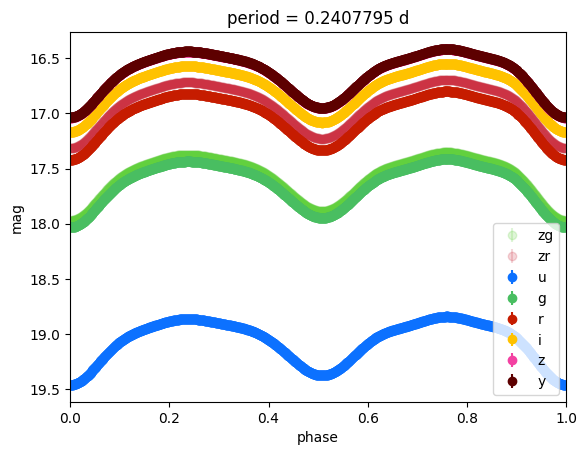

In [10]:
mag_pred_grid = model.apply(params, t, yerr, y, t_gp_grid)[1]
pred_df = pd.DataFrame(
    {
        "band": band_gp_grid,
        "mjd": phase_gp_grid * PERIOD,
        "mag": mag_pred_grid,
        "magerr": np.zeros(N_BANDS * n_grid_band),
    }
)
plot_lc(pred_df, period=PERIOD)

### 3. Simulate a single object

Now when we have a function which gives us apparent magnitude of our source for any of LSST (and two of ZTF!) passbands, we can use it to create a "light-curve source".
Let's start with the built-in `LightcurveSource` class, and in the next section we will extend it to simulate a population.

#### Create `LightcurveSource`

`LightcurveSource` class takes a "grid" model and interpolates it in time, with an optional support of periodic sources.
The grid model is basically "perfect" observations of our light curve, for all passbands.

**Note**: tdastro, as well as Rubin, operates with bandfluxes in nJy, not with magnitudes.

First of all, we will run our model on a grid, convert outputs to nJy, and reformat the result to use it with `LightcurveSource` constructor.

In [11]:
def bandflux_model(phase, band):
    """Output bandflux in nJy for given MJD and band."""
    orig_shape = shape = np.broadcast_shapes(np.shape(phase), np.shape(band))
    if shape == ():
        shape = (1,)
    phase = np.broadcast_to(phase, shape)
    band = np.broadcast_to(band, shape)
    band_one_hot = np.asarray([BAND_ENCODINGS[x] for x in band])
    t_grid = np.hstack([phase[:, None], band_one_hot])
    mag = np.asarray(model.apply(params, t, yerr, y, t_grid)[1])
    flux = mag2flux(mag)
    return flux.reshape(orig_shape)


n_source_grid = 1000
phase_source_grid = np.linspace(0.0, 1.0, n_source_grid)
mjd_source_grid = phase_source_grid * PERIOD
# LSST bassbands only
lightcurve_grid = {
    band: np.stack([mjd_source_grid, bandflux_model(phase_source_grid, band)], axis=-1) for band in "ugrizy"
}

##### LSST cadence and noise simulations

Before we initialize the source, we need to get LSST cadence and noise simulations, OpSim.
You can either download it locally first, or make tdastro to fetch it for you.
Here we fetch it.

In [12]:
opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"
opsim_data = OpSim.from_url(opsim_url)

2025-07-25 13:26:10,981 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/opsim/baseline_v3.4_10yrs.db already exists. Skipping download.


##### Initialize `LightcurveSource`

Let's initialize LightcurveSource object with our light curve grid and LSST passbands.
For simplicity, we will use the uniform sky position distribution.

In [13]:
# Time offset
lightcurve_t0 = NumpyRandomFunc("uniform", low=0.0, high=PERIOD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST")

fov_radius = np.sqrt(9.6 / np.pi)
radec_node = OpSimUniformRADECSampler(opsim_data, radius=fov_radius, node_label="radec")

lightcurve_source = LightcurveSource(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    periodic=True,
    t0=lightcurve_t0,
    ra=radec_node.ra,
    dec=radec_node.dec,
)

2025-07-25 13:26:35,801 - INFO - Loading passbands from preset LSST
2025-07-25 13:26:35,802 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/u.dat already exists. Skipping download.
2025-07-25 13:26:35,802 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/u.dat
2025-07-25 13:26:35,808 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/g.dat already exists. Skipping download.
2025-07-25 13:26:35,808 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/g.dat
2025-07-25 13:26:35,813 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/r.dat already exists. Skipping download.
2025-07-25 13:26:35,813 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/r.dat
2025-07-25 13:26:35,818 - INFO - Data file /Users/hombit/projects/lincc

#### Run simulations!

In [14]:
simulation = simulate_lightcurves(lightcurve_source, 1, opsim_data, lsst_passbands)
simulation

id         ra        dec  nobs     z  \
0   0  74.791619 -34.358861   814  None   

                                              params  \
0  {'radec.ra': 74.79161897277173, 'radec.dec': -...   

                                          lightcurve  
0  [{mjd: 60926.355087, filter: 'y', flux: 559186...

In [15]:
simulated_lightcurve = simulation["lightcurve"].iloc[0]
simulated_lightcurve

,mjd,filter,flux,fluxerr,flux_perfect
0,60926.355087,y,559186.436298,1296.259292,558809.578261
1,60926.379060,y,810077.638327,1579.958076,810967.425721
...,...,...,...,...,...
812,64421.010855,u,77773.989139,639.386421,76274.798274
813,64421.034148,r,412493.574908,666.840399,412929.565953


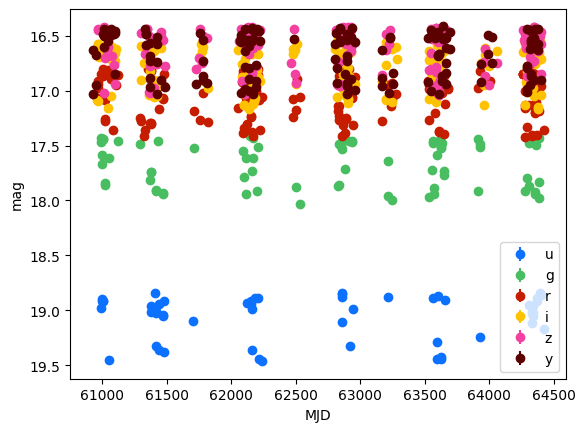

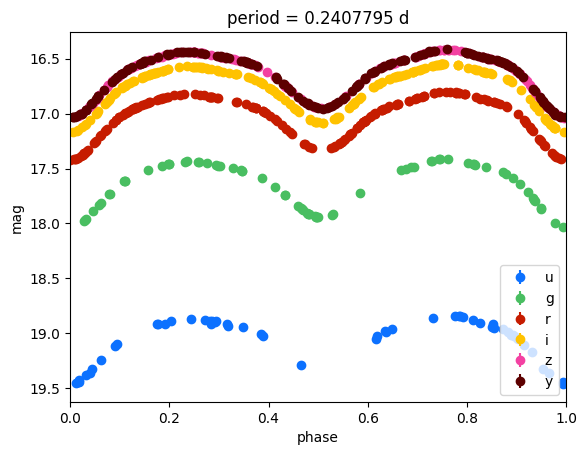

In [16]:
def flux_to_mag_df(df):
    df = df.copy()
    df = df.query("flux > 0")
    df["mag"] = flux2mag(df["flux"])
    df["magerr"] = 2.5 / np.log(10) * df["fluxerr"] / df["flux"]
    df["band"] = df["filter"]
    return df


mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)
plot_lc(mag_sim_lightcurve, period=PERIOD)

### Simulate a population.

We've just seen how 10-year LSST survey will fill the phase space for this object! After that, it would be interesting to see how a similar object located on a large distance would look like.
Again, we are not aimed to make the spatial distribution realistic, so we will use a simple power-law for the distance sampling.

#### Create a new Source class

First, we create a new Source class to incorporate new parameters we'd like to introduce.
For that we inherit from `LightcurveSource`, add new parameters, and change the output values accordingly.

In [17]:
class EclipsingSource(LightcurveSource):
    def __init__(
        self,
        lightcurves,
        passbands,
        *,
        distance_pc,
        period_day,
        phase0,
        **kwargs,
    ):
        super().__init__(
            lightcurves,
            passbands,
            periodic=True,
            baseline=None,
            t0=0.0,
            **kwargs,
        )
        self.add_parameter("distance_pc", value=distance_pc)
        self.add_parameter("period_day", value=period_day)
        self.add_parameter("phase0", value=phase0)

    def compute_bandflux(self, times, filters, state, **kwargs):
        params = self.get_local_params(state)

        phase = times / params["period_day"] - params["phase0"]
        real_object_bandflux = super().compute_bandflux(phase * PERIOD, filters, state, **kwargs)
        return real_object_bandflux * (DISTANCE / params["distance_pc"]) ** 2

#### Run simulations!

Let's create parameter distributions and initialize the Source class and the simulations.

In [18]:
# Let's define old parameters again

# Phase offset
phase0 = NumpyRandomFunc("uniform", low=0.0, high=1.0)

# Period
period_day = NumpyRandomFunc("normal", loc=PERIOD, scale=0.1 * PERIOD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST")

# Uniform positional distribution
fov_radius = np.sqrt(9.6 / np.pi)
radec_node = OpSimUniformRADECSampler(opsim_data, radius=fov_radius, node_label="radec")

# Homogeneous distance distribution, up to 20kpc
max_distance_pc = 20_000.0
distance_pc = FunctionNode(
    lambda rnd: rnd * max_distance_pc,
    node_label="distance_pc",
    rnd=NumpyRandomFunc("power", a=2),
)

eclipsing_source = EclipsingSource(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    distance_pc=distance_pc,
    period_day=period_day,
    phase0=phase0,
    ra=radec_node.ra,
    dec=radec_node.dec,
)

sims = simulate_lightcurves(
    eclipsing_source,
    100,
    opsim_data,
    lsst_passbands,
    param_cols=["distance_pc.function_node_result", "EclipsingSource_0.period_day"],
)
sims = sims.drop(columns=["params"])
sims = sims.rename(
    columns={
        "distance_pc_function_node_result": "distance",
        "EclipsingSource_0_period_day": "period",
    }
)
sims

2025-07-25 13:26:36,354 - INFO - Loading passbands from preset LSST
2025-07-25 13:26:36,354 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/u.dat already exists. Skipping download.
2025-07-25 13:26:36,354 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/u.dat
2025-07-25 13:26:36,360 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/g.dat already exists. Skipping download.
2025-07-25 13:26:36,360 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/g.dat
2025-07-25 13:26:36,364 - INFO - Data file /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/r.dat already exists. Skipping download.
2025-07-25 13:26:36,364 - INFO - Loading passband from file: /Users/hombit/projects/lincc-frameworks/tdastro/data/passbands/LSST/r.dat
2025-07-25 13:26:36,369 - INFO - Data file /Users/hombit/projects/lincc

id          ra        dec  nobs     z      distance    period  \
0    0  303.252165 -19.126426   933  None  11789.253837  0.198341   
1    1  347.029440 -50.048216   902  None  18580.290942  0.248589   
..  ..         ...        ...   ...   ...           ...       ...   
98  98  329.028476 -38.546556   887  None  18055.540813  0.217974   
99  99  181.646843   8.231499   844  None  14981.625244  0.250199   

                                           lightcurve  
0   [{mjd: 60816.417142, filter: 'z', flux: 19070....  
1   [{mjd: 60862.44391, filter: 'y', flux: 6871.62...  
..                                                ...  
98  [{mjd: 60843.444801, filter: 'z', flux: 5829.8...  
99  [{mjd: 60798.028647, filter: 'g', flux: 4524.7...  

[100 rows x 8 columns]

(26.0, 21.0)

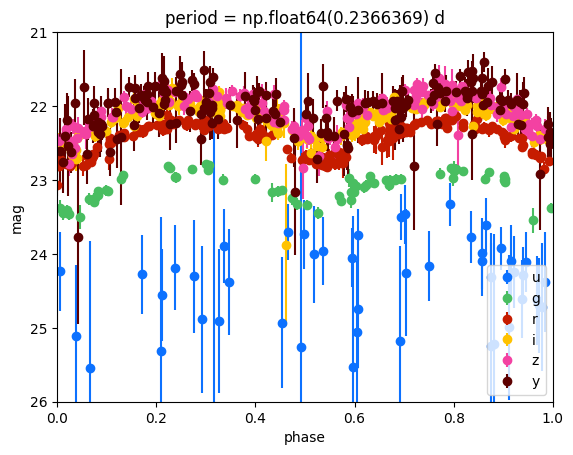

In [19]:
furthest_row = sims.loc[sims["distance"].idxmax()]
model_eclipsing = furthest_row["lightcurve"]
plot_lc(flux_to_mag_df(model_eclipsing), period=np.round(furthest_row["period"], 7))
plt.ylim([26, 21])